This notebook analyzes what happens when an input is split into two, and each half is fed separately into the model. The entropies should respect the joint-marginal entropy bound, given by $S(X) <= S(X,Y) <= S(X) + S(Y)$. This means the entire input should have more entropy than one half, while having less information than the sum of each half entropy. 

Authors: Oscar Skean

# Splitting Sentences

In [1]:
%load_ext autoreload
%autoreload 2

from transformers import AutoTokenizer, AutoModelForCausalLM, GPT2LMHeadModel, GPT2Model, AutoModel
import torch
import numpy as np
import tqdm
from utils import get_model_path, get_dataloader, normalize
import repitl.matrix_itl as itl
import math

device = "cuda:0"

In [51]:
def calculate_split_entropies(model, dataloader, alpha=2, split_on_sentences=False):
    entropy_list = {
        'first': [],
        'second': [],
        'full': []
    }
    counter = 0

    with torch.no_grad():
        for batch in tqdm.tqdm(dataloader, total=300):
            counter += 1
            N = batch['attention_mask'][0].shape[0]
            
            split_attention_mask = batch['attention_mask'][0].chunk(2, dim=0)
            split_input_ids =  batch['input_ids'][0].chunk(2, dim=0)
            split_inputs = [
                {'input_ids': split_input_ids[idx].unsqueeze(0),
                 'attention_mask': split_attention_mask[idx].unsqueeze(0)
                 } for idx in range(len(split_input_ids))
            ]
            split_inputs.append(batch) # process full sentence too

            # process each split input
            for name, inp in zip(['first', 'second', 'full'], split_inputs):
                inp = {k: v.to(device) for k, v in inp.items()}
                outputs = model(**inp)
                N, D = outputs.hidden_states[0].shape[1:]
                
                B_list = [normalize(x.squeeze()) for x in outputs.hidden_states[1:]]
                B_cov_list = []
                for B in B_list:
                    B = B.squeeze()
                    if N > D:
                        B_cov = B.T @ B
                    else:
                        B_cov = B @ B.T
                    B_cov /= torch.trace(B_cov)
                    B_cov = torch.clamp(B_cov, min=0)
                    B_cov_list.append(B_cov)

                B_entropy_list = []
                for B_cov in B_cov_list:
                    entropy_B = itl.matrixAlphaEntropy(B_cov, alpha=alpha).item() / (math.log(D))
                    B_entropy_list.append(entropy_B)

                entropy_list[name].append(B_entropy_list)

            if counter > 300:
                break

    return entropy_list

In [68]:
def calculate_split_mi(model, dataloader, alpha=2, split_on_sentences=False):
    mis_list = []
    joints_list = []
    counter = 0

    with torch.no_grad():
        for batch in tqdm.tqdm(dataloader, total=300):
            counter += 1
            N = batch['attention_mask'][0].shape[0]
            
            split_attention_mask = batch['attention_mask'][0].chunk(2, dim=0)
            split_input_ids =  batch['input_ids'][0].chunk(2, dim=0)
            split_inputs = [
                {'input_ids': split_input_ids[idx].unsqueeze(0),
                 'attention_mask': split_attention_mask[idx].unsqueeze(0)
                 } for idx in range(len(split_input_ids))
            ]

            covs = []
            # process each split input
            for inp in zip(['first', 'second'], split_inputs):
                inp = {k: v.to(device) for k, v in inp.items()}
                outputs = model(**inp)
                N, D = outputs.hidden_states[0].shape[1:]
                
                B_list = [normalize(x.squeeze()) for x in outputs.hidden_states[1:]]
                B_cov_list = []
                for B in B_list:
                    B = B.squeeze()

                    B_cov = B.T @ B
                    
                    B_cov /= torch.trace(B_cov)
                    B_cov = torch.clamp(B_cov, min=0)
                    B_cov_list.append(B_cov)

                covs.append(B_cov_list)

            mi_list = []
            joint_list = []
            for layer in range(len(covs[0])):
                entropy_A = itl.matrixAlphaEntropy(covs[0][layer], alpha=alpha)
                entropy_B = itl.matrixAlphaEntropy(covs[1][layer], alpha=alpha)
                entropy_joint = itl.matrixAlphaEntropy(torch.pow(covs[0][layer] * covs[1][layer], 0.5), alpha=alpha)

                mi = entropy_A + entropy_B - entropy_joint
                mi_list.append(mi.item()  / math.log(D))
                joint_list.append(entropy_joint.item() / math.log(D))
            mis_list.append(mi_list)
            joints_list.append(joint_list)
            if counter > 300:
                break

    return mis_list, joints_list

In [69]:
average_layer_firsthalf_entropy = {}
average_layer_secondhalf_entropy = {}
average_layer_full_entropy = {}
average_layer_mi = {}
average_layer_joint = {}

for model_size in ['14m', '70m', '160m', '410m']:
    model_path = get_model_path("EleutherAI", model_size)
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModel.from_pretrained(model_path, output_hidden_states=True).to(device)
    dataloader = get_dataloader(tokenizer, "wikitext", split="train", min_length=100)
    
    print(f"getting entropy for {model_size}")
    results = calculate_split_entropies(model, dataloader, alpha=2)
    
    average_layer_firsthalf_entropy[model_size] = np.array(results['first']).mean(axis=0)
    average_layer_secondhalf_entropy[model_size] = np.array(results['second']).mean(axis=0)
    average_layer_full_entropy[model_size] = np.array(results['full']).mean(axis=0)

    print(f"getting split mi for {model_size}")
    results_mi, results_joint = calculate_split_mi(model, dataloader, alpha=2)
    average_layer_mi[model_size] = np.array(results_mi).mean(axis=0)
    average_layer_joint[model_size] = np.array(results_joint).mean(axis=0)
    

/home/AD/ofsk222/miniconda3/envs/information_plane/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


getting entropy for 14m


100%|██████████| 300/300 [00:06<00:00, 46.52it/s]


getting split mi for 14m


100%|██████████| 300/300 [00:04<00:00, 67.49it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


getting entropy for 70m


100%|██████████| 300/300 [00:06<00:00, 45.95it/s]


getting split mi for 70m


100%|██████████| 300/300 [00:04<00:00, 67.03it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


getting entropy for 160m


100%|██████████| 300/300 [00:12<00:00, 24.29it/s]


getting split mi for 160m


100%|██████████| 300/300 [00:08<00:00, 34.90it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


getting entropy for 410m


100%|██████████| 300/300 [00:23<00:00, 12.50it/s]


getting split mi for 410m


100%|██████████| 300/300 [00:16<00:00, 17.97it/s]


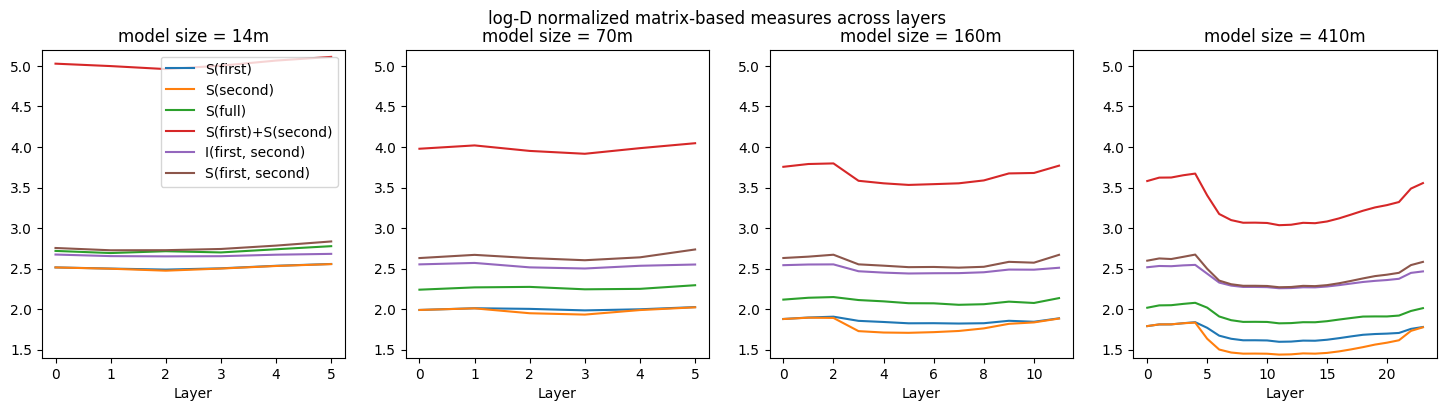

In [73]:
import matplotlib.pyplot as plt
import numpy as np

model_sizes = ['14m', '70m', '160m', '410m']
fig, axes = plt.subplots(1,len(model_sizes), figsize=(len(model_sizes)*4.5, 4))

for idx, model_size in enumerate(model_sizes):
    axes[idx].set_title(f"model size = {model_size}")
    axes[idx].set_xlabel("Layer")

    
    axes[idx].plot(average_layer_firsthalf_entropy[model_size], label='S(first)')
    axes[idx].plot(average_layer_secondhalf_entropy[model_size], label='S(second)')
    axes[idx].plot(average_layer_full_entropy[model_size], label='S(full)')
    axes[idx].plot(average_layer_firsthalf_entropy[model_size]+average_layer_secondhalf_entropy[model_size], label='S(first)+S(second)')
    axes[idx].plot(average_layer_mi[model_size], label='I(first, second)')
    axes[idx].plot(average_layer_joint[model_size], label='S(first, second)')
    axes[idx].set_ylim(1.4, 5.2)

axes[0].legend()
fig.suptitle("log-D normalized matrix-based measures across layers")
plt.show()